In [1]:
# Bruno Ugolini

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlalchemy import create_engine
import os

# 1.1 Movies Database

Take the movies dataset and turn it into a single `sqlite` database. It should have one table for each csv file in the movies dataset

In [4]:
from os import listdir


In [5]:
mypath = '../../Module_3/3_5/the-movies-dataset/'

files = listdir(mypath)
names = [x.split('.')[0] for x in files]

names

['credits',
 'keywords',
 'links',
 'links_small',
 'movies_metadata',
 'ratings',
 'ratings_small']

In [7]:
conn = sqlite3.connect('movies_test')

In [8]:
for name in names:
    df = pd.read_csv(mypath+name+'.csv')
    df.to_sql(
        name=name,
        con=conn,
        schema=None, 
        if_exists='replace', 
        index=True, 
    )

D:\Users\Pinhead\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
pd.read_sql("SELECT name FROM sqlite_MASTER WHERE type='table'", con=conn)

,name
0,credits
1,keywords
2,links
3,links_small
4,movies_metadata
5,ratings
6,ratings_small


# 1.2 Queries

**1.2.1** Use a single query to pull the original title of movies with a budget above $5m

**1.2.2** Use a query to pull the english-language films with the word `war` in their title

**1.2.3** Left join the average ratings from the `ratings` table onto the `movies_metadata` table, so you can have a relation between budget and rating. Hint: use a subquery.

## Question 1.2.1: Use a single query to pull the original title of movies with a budget above $5m

In [10]:
c = conn.cursor()
cursor = c.execute(f"SELECT * FROM movies_metadata")
column_names = list(map(lambda x: x[0], cursor.description))
print(column_names)

['index', 'adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']


In [11]:
pd.read_sql_query(
"""
SELECT  
    original_title,
    budget
FROM movies_metadata
--- this is a SQL code comment
WHERE cast(budget as float) > 5000000
""", 
    con=conn
)

,original_title,budget
0,Toy Story,30000000
1,Jumanji,65000000
2,Waiting to Exhale,16000000
3,Heat,60000000
4,Sabrina,58000000
...,...,...
5166,Detroit,34000000
5167,சிவாஜி,12000000
5168,Pattaya,5402000
5169,Les Visiteurs: La Révolution,25868826


## Question 1.2.2: Use a query to pull the english-language films with the word war in their title

In [12]:
pd.read_sql_query(
"""
SELECT  
    original_title,
    original_language
FROM movies_metadata
--- this is a SQL code comment
WHERE 
    (
    original_title LIKE '% war %' 
    OR original_title LIKE '% war' 
    OR original_title LIKE 'war %' 
    OR original_title = 'war'
    )
    AND original_language LIKE '%en%'
""", 
    con=conn
)

,original_title,original_language
0,The War,en
1,The War Room,en
2,War Stories Our Mother Never Told Us,en
3,In Love and War,en
4,The War at Home,en
...,...,...
118,The 24 Hour War,en
119,War Don Don,en
120,War for the Planet of the Apes,en
121,Underworld: Endless War,en


## Question 1.2.3: Left join the average ratings from the ratings table onto the movies_metadata table, so you can have a relation between budget and rating. Hint: use a subquery.

In [13]:
c = conn.cursor()
cursor = c.execute(f"SELECT * FROM movies_metadata")
column_names = list(map(lambda x: x[0], cursor.description))
print(column_names)

['index', 'adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']


In [15]:
sql_query = """
SELECT  
    *
FROM movies_metadata
LEFT JOIN (
    SELECT
        movieId,
        AVG(ratings.rating) as avg_rating
    FROM
        ratings
    GROUP BY
        movieId
)
ON
    movies_metadata.id = movieId
"""

In [16]:
dfs = []
for chunk in pd.read_sql_query(sql_query, con=conn, chunksize=1000):
    dfs.append(chunk)

In [17]:
df = pd.concat(dfs)
df

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId,avg_rating
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,Toy Story,0.0,7.7,5415.0,862.0,3.598930
1,1,False,None,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",None,8844,tt0113497,en,Jumanji,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,0.0,6.9,2413.0,8844.0,3.760163
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",None,15602,tt0113228,en,Grumpier Old Men,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,0.0,6.5,92.0,NaN,NaN
3,3,False,None,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",None,31357,tt0114885,en,Waiting to Exhale,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,0.0,6.1,34.0,NaN,NaN
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",None,11862,tt0113041,en,Father of the Bride Part II,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,0.0,5.7,173.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,45461,False,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,...,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,0.0,4.0,1.0,NaN,NaN
462,45462,False,None,0,"[{'id': 18, 'name': 'Drama'}]",None,111109,tt2028550,tl,Siglo ng Pagluluwal,...,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,None,Century of Birthing,0.0,9.0,3.0,111109.0,2.583333
463,45463,False,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",None,67758,tt0303758,en,Betrayal,...,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,0.0,3.8,6.0,NaN,NaN
464,45464,False,None,0,[],None,227506,tt0008536,en,Satana likuyushchiy,...,87.0,[],Released,None,Satan Triumphant,0.0,0.0,0.0,NaN,NaN


# 2. Baseball Database

The [Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) has an sqlite version. Download it for these exercises.

**2.1** Which player has had the most homeruns?

**2.2** Is there a relation between how many homeruns a player has made in a year and his salary that year? Pull both colums together in a single query



## 2.1: Which player has had the most homeruns?

In [18]:
conn = sqlite3.connect('data/lahmansbaseballdb.sqlite')
c = conn.cursor()

In [19]:
pd.read_sql("SELECT name FROM sqlite_MASTER WHERE type='table'", con=conn)

,name
0,allstarfull
1,appearances
2,awardsmanagers
3,awardsplayers
4,awardssharemanagers
5,awardsshareplayers
6,batting
7,battingpost
8,collegeplaying
9,divisions


In [20]:
cursor = c.execute(f"SELECT * FROM people")
column_names = list(map(lambda x: x[0], cursor.description))
print(column_names)

['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame', 'retroID', 'bbrefID', 'birth_date', 'debut_date', 'finalgame_date', 'death_date']


In [21]:
sql_query = """
SELECT  
    SUM(HR) as sum_HR,
    people.nameFirst,
    people.nameLast
FROM ( batting
    LEFT JOIN
        people
    ON
        batting.playerID = people.playerID
)
GROUP BY batting.playerID
ORDER BY sum_HR DESC
LIMIT 1
"""

In [22]:
dfs = []
for chunk in pd.read_sql_query(sql_query, con=conn, chunksize=1000):
    dfs.append(chunk)

In [23]:
df = pd.concat(dfs)
df

,sum_HR,nameFirst,nameLast
0,762,Barry,Bonds


## 2.2: Is there a relation between how many homeruns a player has made in a year and his salary that year? Pull both colums together in a single query

In [24]:
sql_query = """
SELECT  
    SUM(HR) as sum_HR,
    batting.yearID,
    batting.playerID,
    people.nameFirst,
    people.nameLast,
    salaries.salary
FROM (batting
INNER JOIN people
    ON
        batting.playerID = people.playerID
INNER JOIN salaries
    ON
        batting.playerID = salaries.playerID
        AND batting.yearID = salaries.yearID
    )
GROUP BY batting.playerID, batting.yearID
"""

In [25]:
dfs = []
for chunk in pd.read_sql_query(sql_query, con=conn, chunksize=1000):
    dfs.append(chunk)

In [26]:
df = pd.concat(dfs)
df

,sum_HR,yearID,playerID,nameFirst,nameLast,salary
0,0,2004,aardsda01,David,Aardsma,300000.0
1,0,2007,aardsda01,David,Aardsma,387500.0
2,0,2008,aardsda01,David,Aardsma,403250.0
3,0,2009,aardsda01,David,Aardsma,419000.0
4,0,2010,aardsda01,David,Aardsma,2750000.0
...,...,...,...,...,...,...
495,1,1991,zupcibo01,Bob,Zupcic,100000.0
496,3,1992,zupcibo01,Bob,Zupcic,109000.0
497,2,1993,zupcibo01,Bob,Zupcic,222000.0
498,2,1989,zuvelpa01,Paul,Zuvella,145000.0


<AxesSubplot:xlabel='sum_HR', ylabel='salary'>

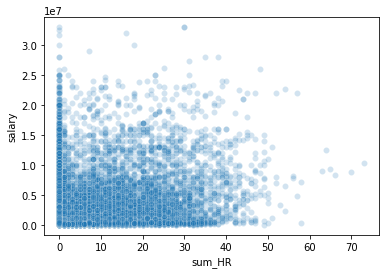

In [27]:
sns.scatterplot(data = df, x='sum_HR', y='salary', alpha=0.2)

In [28]:
X = df['sum_HR']
y = df['salary']

import statsmodels.api as sm

est = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1085.
Date:                Wed, 10 Feb 2021   Prob (F-statistic):          4.35e-233
Time:                        18:32:53   Log-Likelihood:            -4.1915e+05
No. Observations:               25500   AIC:                         8.383e+05
Df Residuals:                   25498   BIC:                         8.383e+05
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.51e+06   2.26e+04     66.948      0.000    1.47e+06    1.55e+06
sum_HR      1.137e+05   3450.307     32.941      0.000    1.07e+05     1.2e+05
==============================================================================
Omnibus:                    16297.767   Durbin-Watson:                   0.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189434.488
Skew:                           2.980   Prob(JB):                         0.00
Kurtosis:                      14.949   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

### Visually (plot above) and mathematically (R-squared of 0.083) there does not appear to be a (linear) relation between home runs and salary paid in a season.